# 汉字书法识别挑战


from [TinyMind第一届汉字书法识别挑战赛](http://www.tinymind.cn/competitions/41)

竞赛数据提供100个汉字书法单字，包括碑帖，手写书法，古汉字等等。图片全部为单通道灰度jpg，宽高不定。

**训练集**

训练集每个汉字400张图片，共计40000张图片，供参赛人员测试和开发参赛算法模型，训练集是标注好的数据，图片按照图片上的文字分类到不同的文件夹中，也就是说文件夹的名字就是文件夹里所有图片的标签。

**测试集**

每汉字100张图片共10000张图片，在竞赛过程中，供参赛人员测试算法模型使用，开放数据下载但不提供标签。比赛过程中，参赛队伍排名以第一部分数据的结果为准。

**提交csv文件**

文件第一列是测试集中图片文件的文件名，第二列是参赛队伍推断出来的图片上文字的可能的五个汉字。
> csv文件编码统一使用utf8编码

In [1]:
import os
import cv2
import glob

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from zipfile import ZipFile
from os.path import isfile, isdir
from datetime import date
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

%matplotlib inline

In [2]:
# 检查文件是否正确下载
assert isfile('train.zip'), "No files: train.zip"
assert isfile('test1.zip'), "No files: test1.zip"

# 解压文件
if not isdir('train'):
    with ZipFile('train.zip', 'r') as zipf:
        for name in tqdm(zipf.namelist(), desc='Extract train_set', unit='files'):
            zipf.extract(name)
        zipf.close()

if not isdir('test1'):
    with ZipFile('test1.zip', 'r') as zipf:
        for name in tqdm(zipf.namelist(), desc='Extract test_set', unit='files'):
            zipf.extract(name)
        zipf.close()

print("All files extracted!")

All files extracted!


shape:  (128, 153)


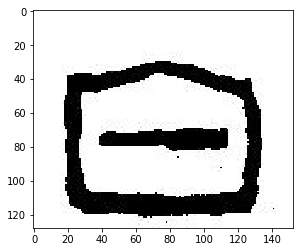

In [3]:
path_eg = './train/白/00801816ca06bdf0b07e56ddfa6c029eeda49dfc.jpg'

image_eg = cv2.imdecode(np.fromfile(path_eg, dtype=np.uint8), 0)

print('shape: ', image_eg.shape)
plt.imshow(image_eg, cmap='gray')
plt.show()

## 提取数据

### 训练集
提取train文件夹中的数据，生成对应的标签，并对标签进行独热编码。

In [3]:
# 建立缓存文件夹和提交文件夹
if not isdir('cache'):
    os.mkdir('cache')
if not isdir('submission'):
    os.mkdir('submission')

In [2]:
is_test = 0
random_seed = 2018

label_char = os.listdir('./train/')
encode_label = LabelBinarizer()
encode_label.fit(label_char)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [5]:
class_num = len(label_char)
print('class_num: ', class_num)

class_num:  100


In [3]:
# 将图片以 np.uint8 格式存储
def get_img(file_path, img_rows, img_cols):
    if ('test1' in file_path):
        image = cv2.imread(file_path, 0)
    else:    # 如果有中文路径
        image = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), 0)
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (img_rows, img_cols))
    feature = np.array(image, dtype=np.uint8)
    
    return feature

In [7]:
def load_train_data(train_path, img_rows, img_cols, test_size=0.2):
    x_train = []
    y_train = []
    
    dirs = os.listdir(train_path)
    dirs_pbar = tqdm(dirs, desc='load train images', total=len(dirs))     #######################
    for dir_name in dirs_pbar:             
        path = train_path + '/' + dir_name
        for img_name in os.listdir(path):
            feature = get_img(path+'/'+img_name, img_rows, img_cols)
            label = dir_name
            
            x_train.append(feature)
            y_train.append(label)
    
    # 对标签独热编码
    y_train = np.array(encode_label.transform(y_train), dtype=np.uint8)
    
    # 对训练集随机打乱，并划分训练集和验证集
    x_train = np.array(x_train, dtype=np.uint8)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
                                                        test_size=0.2, 
                                                        random_state=random_seed)
    return x_train, x_test, y_train, y_test

In [17]:
# 加载测试集数据
def load_test_data(test_path, img_rows, img_cols):
    print('load test data...')
    path = os.path.join(test_path, '*.jpg')
    files = glob.glob(path)
    files_pbar = tqdm(files, desc='load test images', total=len(files))  #########
    
    x_test = np.zeros((len(files), img_rows, img_cols, 3), dtype=np.uint8)  #########
    x_test_id = []
    for i,file in enumerate(files_pbar):
        file_name = os.path.basename(file)
        feature = get_img(file, img_rows, img_cols)
        x_test[i] = feature
        x_test_id.append(file_name)
        
    print("test data loaded!")
    
    return x_test, x_test_id

In [10]:
# fine-tune 模型
def fine_tune_model(MODEL, img_rows, img_cols, optimizer, batch_size, epochs, freeze_num):
    '''
    discription: 对指定预训练模型进行fine-tune，并保存为.hdf5格式
    
    MODEL：传入的模型，VGG16， ResNet50, ...
    img_rows, img_cols：图片缩放后的大小
    optimizer: fine-tune all layers 的优化器, first part默认用adadelta
    batch_size: 每一批的尺寸，建议32/64/128
    epochs: fine-tune all layers的代数
    freeze_num: first part冻结卷积层的数量
    '''
    train_path = './train'
    model = MODEL(img_rows, img_cols)
    
    x_train, x_val, y_train, y_val = load_train_data(train_path, img_rows, img_cols, test_size=0.2)
    
    # 展示数据集的基本情况
    print('x_train shape: ', x_train.shape)
    print('y_train shape: ', y_train.shape)
    print('x_val shape: ', x_val.shape)
    print('y_val shape: ', y_val.shape)

    # first: 仅训练全连接层（权重随机初始化的）
    # 冻结所有卷积层
    for layer in model.layers[:freeze_num]:
        layer.trainable = False
    model.compile(optimizer='adadelta', loss='categorical_crossentropy',
                      metrics=['accuracy'])
    model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=2, shuffle=True, 
              verbose=1, validation_data=(x_val, y_val))
    print('Finish step_1')
    
    # second: fine-tune all layers
    for layer in model.layers[:]:
        layer.trainable = True
    es = EarlyStopping(monitor='val_loss', patience=4)
    model_name = model.name + '-' + str(date.today()) + '.hdf5'
    mc = ModelCheckpoint(os.path.join('cache', model_name), monitor='val_loss', 
                         save_best_only=True, mode='min')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history_fit = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, 
                           shuffle=True, verbose=1, validation_data=(x_val, y_val),
                           callbacks=[es, mc])
    print('Finish fine-tune')
    
    #展示fine-tune过程中的loss和accuracy变化曲线
    history_plot(history_fit)
    
    # 预测
    pred_val = model.predict(x_val, batch_size=batch_size, verbose=1)
    score_val = log_loss(y_val, pred_val)
    print('Final log_loss: {}, epochs: {}'.format(score_val, epochs))

In [ ]:
# 加载保存的模型，继续fine-tune
def train_from_checkpoint(img_rows, img_cols, model_str, checkpoint_name, optimizer, batch_size, epochs):
    '''
    discription: 加载保存的模型，继续fine-tune，将更新的结果保存为.hdf5格式
    
    img_rows, img_cols：图片缩放后的大小
    optimizer: fine-tune all layers 的优化器, first part默认用adadelta
    batch_size: 每一批的尺寸，建议32/64/128
    epochs: fine-tune all layers的代数

    '''
    train_path = './train'
    custom_objects = {'preprocess_input': imagenet_utils.preprocess_input,
                      '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input}
    model = load_model(os.path.join('cache', checkpoint_name), custom_objects=custom_objects)
    
    x_train, x_val, y_train, y_val = load_train_data(train_path, img_rows, img_cols, test_size=0.2)
    
    # 展示数据集的基本情况
    print('x_train shape: ', x_train.shape)
    print('y_train shape: ', y_train.shape)
    print('x_val shape: ', x_val.shape)
    print('y_val shape: ', y_val.shape)

    # fine-tune all layers
    es = EarlyStopping(monitor='val_loss', patience=4)
    model_name = model.name + '-retrain-' + str(date.today()) + '.hdf5'
    mc = ModelCheckpoint(os.path.join('cache', model_name), monitor='val_loss', 
                         save_best_only=True, mode='min')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history_fit = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, 
                           shuffle=True, verbose=1, validation_data=(x_val, y_val),
                           callbacks=[es, mc])
    print('Finish fine-tune')
    
    # 展示fine-tune过程中的loss和accuracy变化曲线
    history_plot(history_fit)
    
    # 预测
    pred_val = model.predict(x_val, batch_size=batch_size, verbose=1)
    score_val = log_loss(y_val, pred_val)
    print('Final log_loss: {}, epochs: {}'.format(score_val, epochs))

In [14]:
def test_predict_and_submit(img_rows, img_cols, model_str, model_name, epochs):
    test_path = './test1'
    
    test_data, test_id = load_test_data(test_path, img_rows, img_cols)
    
    custom_objects = {'preprocess_input': imagenet_utils.preprocess_input,
                          '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input}
    model = load_model(os.path.join('cache', model_name), custom_objects=custom_objects)
    test_pred = model.predict(test_data, batch_size=32, verbose=1)
    info_string = 'loss_' + model_str + '_r_' + str(img_rows) + '_c_'\
                  + str(img_cols) + '_ep_' + str(epochs)
    
    # 将结果写入 .csv 文件中
    create_submission(test_pred, test_id, info_string)
    
    print("Finish!")
    

In [12]:
# 绘制训练过程中的 loss 和 acc 变化曲线
def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history['acc'])
    plt.plot(history_fit.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

In [15]:
# 根据传入的预测值，创建 csv文件
def create_submission(preds, test_id, info):
    labels = []
    for i,_ in enumerate(test_id):  
        
        # key代表预测的character的序号，value代表预测概率
        pred_dict = {key:value for key,value in enumerate(preds[i])} 
        pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
        # pred_sorted: [(k1,v1), (k2,v2), ...]
        top_5 = ''
        for j in range(5):
            index = pred_sorted[j][0]
            top_5 += label_char[index]
        
        labels.append(top_5) 
    
    result = DataFrame(labels, columns=['label'])
    result.insert(0, 'filename', test_id)
    now = date.today()
    suffix = info + '_' + now.strftime("%Y%m%d")
    sub_file = os.path.join('submission', 'subm_' + suffix + '.csv')
    result.to_csv(sub_file, index=False)
    
    print("Create submission successfuly")


## fine-tune 模型
选择keras中预训练好的模型，进行fine-tune

In [5]:
# 加载需要的keras模块
from keras import optimizers, Input
from keras import backend as K
from keras.models import Model, load_model, save_model
from keras.layers import Lambda, Dense, Dropout, Conv2D
from keras.applications import VGG16, Xception, imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG

Using TensorFlow backend.


### VGG 16

In [24]:
def vgg16_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = VGG16(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
   # x = Dense(1024, activation='relu', name='fc2')(x)
   # x = Dropout(0.5)(x)
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    vgg_model = Model(inputs=base_model.input, outputs=predictions, name='vgg16')
    
    return vgg_model

load train images: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


x_train shape:  (32000, 224, 224, 3)
y_train shape:  (32000, 100)
x_val shape:  (8000, 224, 224, 3)
y_val shape:  (8000, 100)
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 351s 11ms/step - loss: 4.0170 - acc: 0.1162 - val_loss: 3.0677 - val_acc: 0.2592
Finish step_1
Train on 32000 samples, validate on 8000 samples
Epoch 1/4
32000/32000 [==============================] - 904s 28ms/step - loss: 2.2213 - acc: 0.4328 - val_loss: 1.2172 - val_acc: 0.7116
Epoch 2/4
32000/32000 [==============================] - 914s 29ms/step - loss: 1.1733 - acc: 0.6873 - val_loss: 0.7259 - val_acc: 0.8249
Epoch 3/4
32000/32000 [==============================] - 915s 29ms/step - loss: 0.7656 - acc: 0.7945 - val_loss: 0.6600 - val_acc: 0.8361
Epoch 4/4
32000/32000 [==============================] - 910s 28ms/step - loss: 0.5543 - acc: 0.8477 - val_loss: 0.4766 - val_acc: 0.8782
Finish fine-tune


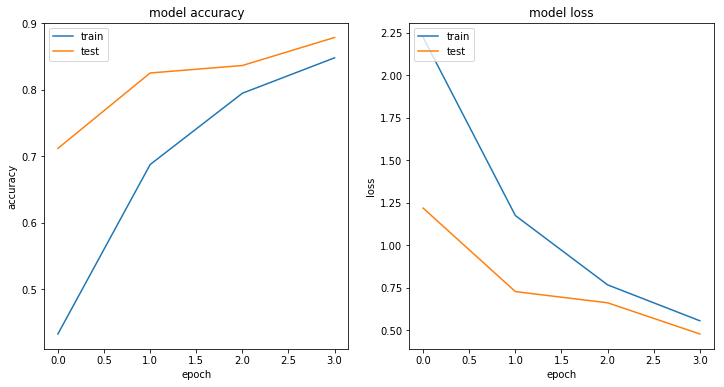

8000/8000 [==============================] - 70s 9ms/step
Final log_loss: 0.4767516372647409, epochs: 4


In [29]:
MODEL = vgg16_model
model_str = 'vgg16'
img_rows, img_cols = 224, 224

#optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
optimizer = optimizers.SGD(lr=0.0005, momentum=0.9)

batch_size = 32
epochs = 4
freeze_num = 19
    
fine_tune_model(MODEL, img_rows, img_cols, optimizer, batch_size, epochs, freeze_num)

#### 从保存的模型中恢复训练

load train images: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


x_train shape:  (32000, 224, 224, 3)
y_train shape:  (32000, 100)
x_val shape:  (8000, 224, 224, 3)
y_val shape:  (8000, 100)
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 939s 29ms/step - loss: 0.4221 - acc: 0.8819 - val_loss: 0.4440 - val_acc: 0.8914
Finish fine-tune


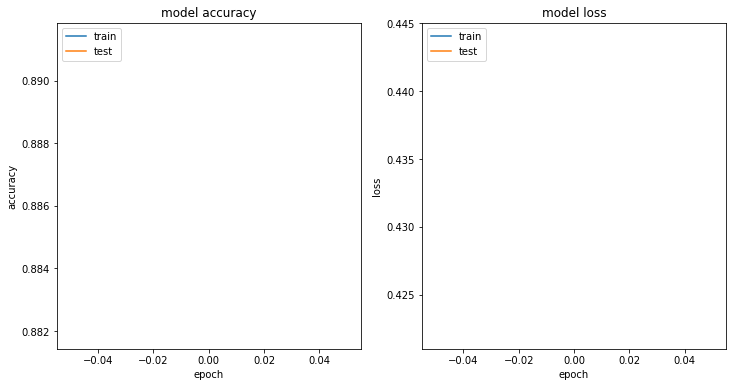

8000/8000 [==============================] - 72s 9ms/step
Final log_loss: 0.4487821297025407, epochs: 1


In [16]:
# 从保存的模型中继续训练
img_rows, img_cols = 224, 224
model_str = 'vgg16'
checkpoint_name = 'vgg16-2018-05-26.hdf5'
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
batch_size = 32
epochs = 10

train_from_checkpoint(img_rows, img_cols, model_str, checkpoint_name, optimizer, batch_size, epochs)

In [65]:
# create vgg-16 submission .csv file
img_rows, img_cols = 224, 224
model_str = 'vgg16'
model_name = 'vgg16-2018-05-25.hdf5'
epochs = 4

test_predict_and_submit(img_rows, img_cols, model_str, model_name, epochs)

load test data...


load test images:   1%|▌                                                           | 100/10000 [00:02<04:06, 40.14it/s]


100/100 [==============================] - ETA: 43 - ETA: 23 - ETA: 2 - 71s 712ms/step
Create submission successfuly


In [6]:
## test 3-1
custom_objects = {'preprocess_input': imagenet_utils.preprocess_input,
                          '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input}
model = load_model(os.path.join('cache', 'xception-retrain-2018-05-26.hdf5'), custom_objects=custom_objects)
path = os.path.join('./test1', '*.jpg')
files = glob.glob(path)

(150, 150, 3)


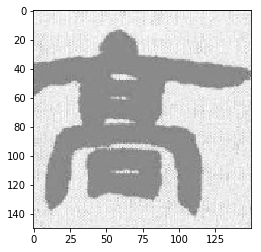

(1, 100)
[[  2.93000152e-10   3.70201647e-11   1.01820948e-10   3.93668550e-13
    4.41404591e-05   4.51013220e-11   3.46392125e-14   1.76526946e-12
    1.05896715e-12   1.62927435e-10   2.45320170e-11   4.33001135e-11
    1.23530775e-12   2.71341586e-12   3.11519636e-13   1.45040762e-08
    7.97371197e-12   5.32744786e-11   8.98004796e-11   1.47106849e-09
    9.09793629e-11   2.27966007e-10   6.43947812e-11   1.57843530e-11
    2.91062595e-12   5.01089925e-12   2.17602824e-12   9.31840976e-12
    6.40605581e-12   1.36088244e-12   1.75724241e-10   1.56453947e-11
    5.24125326e-11   1.17629136e-11   5.07424268e-12   3.49725443e-10
    1.06851639e-10   8.30331776e-11   2.83408505e-11   3.80111692e-10
    7.79940782e-12   1.62328675e-11   2.82172397e-10   2.89643916e-11
    6.72389783e-11   4.79509869e-11   8.17170929e-13   8.15772883e-12
    4.86768937e-13   3.67128827e-11   6.33862754e-11   1.07758719e-10
    3.77164966e-11   1.04615145e-11   7.71040232e-10   2.67952860e-08
    6.11484

In [11]:
## test 3-2
f = get_img(files[100], 150, 150)
print(f.shape)
plt.imshow(f)
plt.show()
f=np.expand_dims(f, axis=0)
pred = model.predict(f)

print(pred.shape)
print(pred)


In [12]:
# test 3-3
labels=[]
pred_dict = {key:value for key,value in enumerate(pred[0])} 
pred_sorted = sorted(pred_dict.items(), key=lambda item:(-item[1])) 
# pred_sorted: [(k1,v1), (k2,v2), ...]
top_5 = ''
for j in range(5):
    index = pred_sorted[j][0]
    top_5 += label_char[index]
        
labels.append(top_5) 

print(labels)

['高亭春去福']


### Xception

In [16]:
# Xception
def xception_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = Xception(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    xception_model = Model(inputs=base_model.input, outputs=predictions, name='xception')
    return xception_model

In [53]:
xception = xception_model(150, 150)
xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 150, 150, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         lambda_3[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

block9_sepconv1_act (Activation (None, 9, 9, 728)    0           add_19[0][0]                     
__________________________________________________________________________________________________
block9_sepconv1 (SeparableConv2 (None, 9, 9, 728)    536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 9, 9, 728)    2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 9, 9, 728)    0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 9, 9, 728)    536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sep

In [54]:
##### 列出每一层的序号和名字
for i,layer in enumerate(xception.layers):
    print(i, layer.name)

0 input_3
1 lambda_3
2 block1_conv1
3 block1_conv1_bn
4 block1_conv1_act
5 block1_conv2
6 block1_conv2_bn
7 block1_conv2_act
8 block2_sepconv1
9 block2_sepconv1_bn
10 block2_sepconv2_act
11 block2_sepconv2
12 block2_sepconv2_bn
13 conv2d_5
14 block2_pool
15 batch_normalization_5
16 add_13
17 block3_sepconv1_act
18 block3_sepconv1
19 block3_sepconv1_bn
20 block3_sepconv2_act
21 block3_sepconv2
22 block3_sepconv2_bn
23 conv2d_6
24 block3_pool
25 batch_normalization_6
26 add_14
27 block4_sepconv1_act
28 block4_sepconv1
29 block4_sepconv1_bn
30 block4_sepconv2_act
31 block4_sepconv2
32 block4_sepconv2_bn
33 conv2d_7
34 block4_pool
35 batch_normalization_7
36 add_15
37 block5_sepconv1_act
38 block5_sepconv1
39 block5_sepconv1_bn
40 block5_sepconv2_act
41 block5_sepconv2
42 block5_sepconv2_bn
43 block5_sepconv3_act
44 block5_sepconv3
45 block5_sepconv3_bn
46 add_16
47 block6_sepconv1_act
48 block6_sepconv1
49 block6_sepconv1_bn
50 block6_sepconv2_act
51 block6_sepconv2
52 block6_sepconv2_bn


In [ ]:
# train Xception
MODEL = xception_model
model_str = 'xception'
img_rows, img_cols = 150, 150
optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
#optimizer = optimizers.SGD(lr=0.001, momentum=0.9)
batch_size = 32
epochs = 10
freeze_num = 133
    
fine_tune_model(MODEL, img_rows, img_cols, optimizer, batch_size, epochs, freeze_num)

load train images: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


x_train shape:  (32000, 150, 150, 3)
y_train shape:  (32000, 100)
x_val shape:  (8000, 150, 150, 3)
y_val shape:  (8000, 100)
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 195s 6ms/step - loss: 3.9388 - acc: 0.1466 - val_loss: 15.4336 - val_acc: 0.0103
Epoch 2/2
32000/32000 [==============================] - 193s 6ms/step - loss: 3.2761 - acc: 0.2691 - val_loss: 15.6713 - val_acc: 0.0097
Finish step_1
Train on 32000 samples, validate on 8000 samples
Epoch 1/4
32000/32000 [==============================] - 689s 22ms/step - loss: 1.0374 - acc: 0.7328 - val_loss: 1.0514 - val_acc: 0.7540
Epoch 2/4
13888/32000 [============>.................] - ETA: 5:59 - loss: 0.3482 - acc: 0.9041

load train images: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


x_train shape:  (32000, 150, 150, 3)
y_train shape:  (32000, 100)
x_val shape:  (8000, 150, 150, 3)
y_val shape:  (8000, 100)
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 688s 22ms/step - loss: 0.0370 - acc: 0.9892 - val_loss: 0.3658 - val_acc: 0.9257
Epoch 2/10
32000/32000 [==============================] - 677s 21ms/step - loss: 0.0310 - acc: 0.9908 - val_loss: 0.2847 - val_acc: 0.9425
Epoch 3/10
32000/32000 [==============================] - 676s 21ms/step - loss: 0.0276 - acc: 0.9917 - val_loss: 0.2885 - val_acc: 0.9421
Epoch 4/10
32000/32000 [==============================] - 676s 21ms/step - loss: 0.0250 - acc: 0.9926 - val_loss: 0.2933 - val_acc: 0.9413
Epoch 5/10
32000/32000 [==============================] - 676s 21ms/step - loss: 0.0203 - acc: 0.9943 - val_loss: 0.2993 - val_acc: 0.9361
Epoch 6/10
32000/32000 [==============================] - 676s 21ms/step - loss: 0.0211 - acc: 0.9937 - val_loss: 0.3210 - val_acc

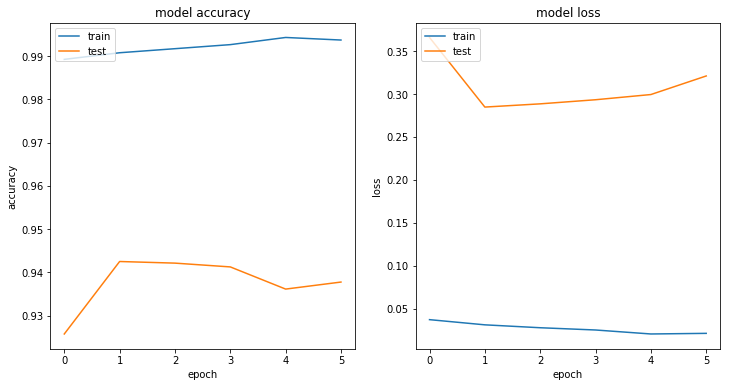

8000/8000 [==============================] - 48s 6ms/step
Final log_loss: 0.3230307900376265, epochs: 10


In [17]:
# 从保存的模型中继续训练
img_rows, img_cols = 150, 150
model_str = 'vgg16'
checkpoint_name = 'xception-2018-05-26.hdf5'
optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
#optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
batch_size = 32
epochs = 10

train_from_checkpoint(img_rows, img_cols, model_str, checkpoint_name, optimizer, batch_size, epochs)

In [18]:
# create xception submission .csv file
img_rows, img_cols = 150, 150
model_str = 'xception'
model_name = 'xception-retrain-2018-05-26.hdf5'
epochs = 10

test_predict_and_submit(img_rows, img_cols, model_str, model_name, epochs)

load test data...


load test images: 100%|██████████████████████████████████████████████████████████| 10000/10000 [03:10<00:00, 52.43it/s]


test data loaded!
10000/10000 [==============================] - ETA: 1:14:5 - ETA: 1:11:0 - ETA: 1:10:3 - ETA: 1:10:0 - ETA: 1:09:4 - ETA: 1:09:1 - ETA: 1:09:0 - ETA: 1:08:5 - ETA: 1:08:4 - ETA: 1:08:2 - ETA: 1:08:0 - ETA: 1:07:5 - ETA: 1:07:3 - ETA: 1:07:2 - ETA: 1:07:1 - ETA: 1:06:5 - ETA: 1:06:4 - ETA: 1:06:2 - ETA: 1:06:1 - ETA: 1:05:5 - ETA: 1:05:4 - ETA: 1:05:3 - ETA: 1:05:1 - ETA: 1:05:0 - ETA: 1:04:4 - ETA: 1:04:3 - ETA: 1:04:2 - ETA: 1:04:1 - ETA: 1:03:5 - ETA: 1:03:4 - ETA: 1:03:2 - ETA: 1:03:1 - ETA: 1:02:5 - ETA: 1:02:4 - ETA: 1:02:2 - ETA: 1:02:1 - ETA: 1:01:5 - ETA: 1:01:4 - ETA: 1:01:3 - ETA: 1:01:1 - ETA: 1:01:0 - ETA: 1:00:4 - ETA: 1:00:3 - ETA: 1:00:2 - ETA: 1:00:0 - ETA: 59:53  - ETA: 59:3 - ETA: 59:2 - ETA: 59:1 - ETA: 58:5 - ETA: 58:4 - ETA: 58:2 - ETA: 58:1 - ETA: 58:0 - ETA: 57:4 - ETA: 57:3 - ETA: 57:2 - ETA: 57:0 - ETA: 56:5 - ETA: 56:3 - ETA: 56:2 - ETA: 56:1 - ETA: 55:5 - ETA: 55:4 - ETA: 55:3 - ETA: 55:1 - ETA: 55:0 - ETA: 54:5 - ETA: 54:4 - ETA: 54:3 - ETA